In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets

import utils.metrics
import utils.model

In [4]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3, 1), 'GB')

Using device: cpu



In [5]:
data_train = torchvision.datasets.FashionMNIST(
    "fmnist", download=True, train=True, transform=torchvision.transforms.ToTensor())
data_loader_train = torch.utils.data.DataLoader(data_train,
                                                batch_size=32,
                                                shuffle=True,
                                                )

data_test = torchvision.datasets.FashionMNIST(
    "fmnist", download=True, train=False, transform=torchvision.transforms.ToTensor())
data_loader_test = torch.utils.data.DataLoader(data_test,
                                               batch_size=32,
                                               shuffle=False)

D:\jiriv\miniconda\envs\mlops-template\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
dataset_sizes = {"train": len(data_train), "val": len(data_test)}
data_loaders = {"train": data_loader_train, "val": data_loader_test}
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress",
               "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self, p_dropout):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(p=p_dropout),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [13]:
model = NeuralNetwork(p_dropout=0).to(device)
print(model)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
train_progress = utils.model.train_model(
    model, 5, optimizer, criterion, data_loaders, dataset_sizes)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Dropout(p=0, inplace=False)
    (5): Linear(in_features=512, out_features=10, bias=True)
  )
)
Epoch 1/5
----------


train Loss: 1.01 Acc: 0.67 Avg. conf: 0.46 Avg. max. prob: 0.53: 100%|██████████| 1875/1875 [00:47<00:00, 39.78it/s]
val Loss: 0.64 Acc: 0.78 Avg. conf: 0.66 Avg. max. prob: 0.71: 100%|██████████| 313/313 [00:03<00:00, 92.44it/s]

Epoch 2/5
----------



train Loss: 0.56 Acc: 0.81 Avg. conf: 0.72 Avg. max. prob: 0.76: 100%|██████████| 1875/1875 [00:43<00:00, 42.99it/s]
val Loss: 0.53 Acc: 0.81 Avg. conf: 0.74 Avg. max. prob: 0.79: 100%|██████████| 313/313 [00:03<00:00, 85.83it/s]

Epoch 3/5
----------



train Loss: 0.49 Acc: 0.83 Avg. conf: 0.76 Avg. max. prob: 0.80: 100%|██████████| 1875/1875 [00:45<00:00, 41.13it/s]
val Loss: 0.51 Acc: 0.82 Avg. conf: 0.77 Avg. max. prob: 0.81: 100%|██████████| 313/313 [00:03<00:00, 91.20it/s]

Epoch 4/5
----------



train Loss: 0.45 Acc: 0.84 Avg. conf: 0.79 Avg. max. prob: 0.82: 100%|██████████| 1875/1875 [00:50<00:00, 37.41it/s]
val Loss: 0.49 Acc: 0.82 Avg. conf: 0.79 Avg. max. prob: 0.82: 100%|██████████| 313/313 [00:04<00:00, 75.60it/s]

Epoch 5/5
----------



train Loss: 0.43 Acc: 0.85 Avg. conf: 0.80 Avg. max. prob: 0.83: 100%|██████████| 1875/1875 [00:54<00:00, 34.10it/s]
val Loss: 0.45 Acc: 0.84 Avg. conf: 0.80 Avg. max. prob: 0.83: 100%|██████████| 313/313 [00:03<00:00, 102.42it/s]


In [14]:
def plot_uncertainties(progress):
    correct = progress.predictions == progress.labels
    mc_dropout_confidence = 1 - val_progress.dropout_variances / \
        val_progress.dropout_variances.max()
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.violinplot([progress.confidences, progress.max_probs, mc_dropout_confidence,
                   progress.confidences[correct], progress.max_probs[correct], mc_dropout_confidence[correct],
                   progress.confidences[~correct], progress.max_probs[~correct], mc_dropout_confidence[~correct]])

    print(
        f"All predictions mean confidence: {np.mean(progress.confidences)}, "
        f"Prob: {np.mean(progress.max_probs)}, "
        f"Var: {mc_dropout_confidence.mean()}")
    print(
        f"Correct predictions mean confidence: {np.mean(progress.confidences[correct])}, "
        f"Prob: {np.mean(progress.max_probs[correct])}, "
        f"Var: {mc_dropout_confidence[correct].mean()}")
    print(
        f"Incorrect predictions mean confidence: {np.mean(progress.confidences[~correct])}, "
        f"Prob: {np.mean(progress.max_probs[~correct])}, "
        f"Var: {mc_dropout_confidence[~correct].mean()}")

In [16]:
utils.mc_dropout.set_dropout_p(model, model, .5)
val_progress = utils.model.run_validation(
    model, data_loaders["val"], utils.metrics.Progress(), device)

Avg. acc.: 0.84: 100%|██████████| 313/313 [00:03<00:00, 90.33it/s]


In [18]:
utils.mc_dropout.set_dropout_p(model, model, .5)
val_progress = utils.model.run_validation(
    model, data_loaders["val"], utils.metrics.Progress(), device, use_mc_dropout=True)

Avg. acc.: 0.84: 100%|██████████| 313/313 [00:29<00:00, 10.62it/s]


All predictions mean confidence: 0.796882053399086, Prob: 0.8319714024603367, Var: 0.8241281093936217
Correct predictions mean confidence: 0.8351788852161944, Prob: 0.8720344356246285, Var: 0.849513782294247
Incorrect predictions mean confidence: 0.5907830216737028, Prob: 0.6163673445953255, Var: 0.6875120407459043


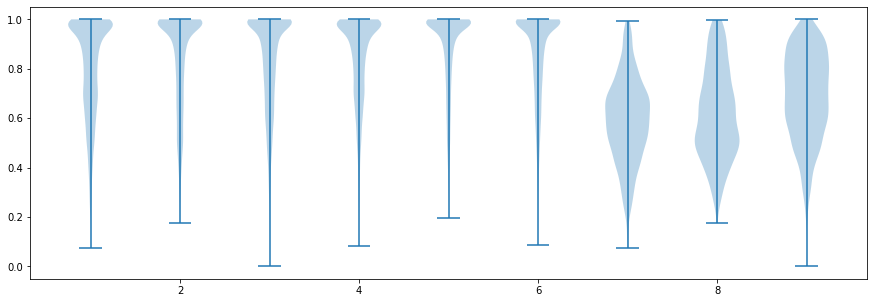

In [19]:
plot_uncertainties(val_progress)

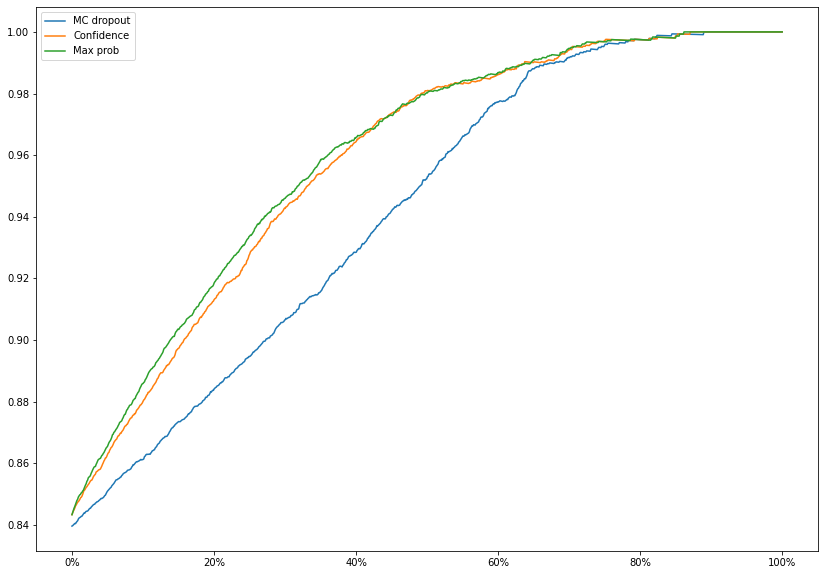

In [20]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(1, 1, 1)
for label, idx in [("MC dropout", np.argsort(val_progress.dropout_variances)[::-1]),
                   ("Confidence", np.argsort(val_progress.confidences)),
                   ("Max prob", np.argsort(val_progress.max_probs))]:
    labels = val_progress.labels[idx]
    predictions = val_progress.dropout_predictions[
        idx] if label == "MC dropout" else val_progress.predictions[idx]
    accs = utils.metrics.roc_stat(labels, predictions, step=10)
    ax.plot(np.linspace(0, 100, len(accs)), accs, label=label)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend()